# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
#!mkdir cifar10
#!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_val = X_test
y_val = y_test

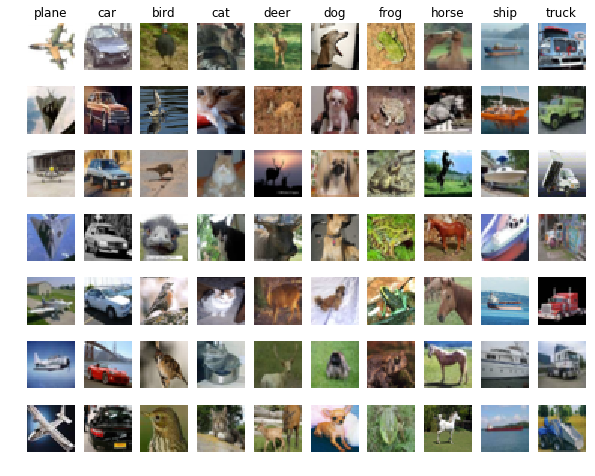

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne import init
from lasagne.layers import batch_norm
input_X = T.tensor4("X", dtype='float32')
target_y = T.vector("target Y integer",dtype='int32')

In [29]:
from lasagne.layers import Conv2DLayer as ConvLayer
#from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import GlobalPoolLayer
from lasagne.layers import PadLayer
from lasagne.layers import ExpressionLayer
from lasagne.layers import NonlinearityLayer
from lasagne.nonlinearities import softmax, rectify
from lasagne.layers import batch_norm

def build_cnn(input_var=None, n=5):
    
    # create a residual learning building block with two stacked 3x3 convlayers as in paper
    def residual_block(l, increase_dim=False, projection=False):
        input_num_filters = l.output_shape[1]
        if increase_dim:
            first_stride = (2,2)
            out_num_filters = input_num_filters*2
        else:
            first_stride = (1,1)
            out_num_filters = input_num_filters

        stack_1 = batch_norm(ConvLayer(l, num_filters=out_num_filters, filter_size=(3,3), stride=first_stride, nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
        stack_2 = batch_norm(ConvLayer(stack_1, num_filters=out_num_filters, filter_size=(3,3), stride=(1,1), nonlinearity=None, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
        
        # add shortcut connections
        if increase_dim:
            if projection:
                # projection shortcut, as option B in paper
                projection = batch_norm(ConvLayer(l, num_filters=out_num_filters, filter_size=(1,1), stride=(2,2), nonlinearity=None, pad='same', b=None, flip_filters=False))
                block = NonlinearityLayer(ElemwiseSumLayer([stack_2, projection]),nonlinearity=rectify)
            else:
                # identity shortcut, as option A in paper
                identity = ExpressionLayer(l, lambda X: X[:, :, ::2, ::2], lambda s: (s[0], s[1], s[2]//2, s[3]//2))
                padding = PadLayer(identity, [out_num_filters//4,0,0], batch_ndim=1)
                block = NonlinearityLayer(ElemwiseSumLayer([stack_2, padding]),nonlinearity=rectify)
        else:
            block = NonlinearityLayer(ElemwiseSumLayer([stack_2, l]),nonlinearity=rectify)
        
        return block

    # Building the network
    l_in = InputLayer(shape=(None, 3, 32, 32), input_var=input_var)

    # first layer, output is 16 x 32 x 32
    l = batch_norm(ConvLayer(l_in, num_filters=16, filter_size=(3,3), stride=(1,1), nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
    
    # first stack of residual blocks, output is 16 x 32 x 32
    for _ in range(n):
        l = residual_block(l)

    # second stack of residual blocks, output is 32 x 16 x 16
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)

    # third stack of residual blocks, output is 64 x 8 x 8
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)
    
    # average pooling
    l = GlobalPoolLayer(l)

    # fully connected layer
    network = DenseLayer(
            l, num_units=10,
            W=lasagne.init.HeNormal(),
            nonlinearity=softmax)

    return network
net = build_cnn(input_X, n=5)

In [30]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [31]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [32]:
updates = lasagne.updates.adam(loss, all_weights, learning_rate=0.01)
#updates = lasagne.updates.adadelta(loss, all_weights, learning_rate=0.01)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True, on_unused_input='ignore')
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [33]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [34]:
import time

num_epochs = 7 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 7 took 3011.513s
  training loss (in-iteration):		1.621691
  train accuracy:		39.66 %
  validation accuracy:		52.97 %
Epoch 2 of 7 took 2960.036s
  training loss (in-iteration):		1.097140
  train accuracy:		60.18 %
  validation accuracy:		66.00 %
Epoch 3 of 7 took 2950.932s
  training loss (in-iteration):		0.849210
  train accuracy:		69.75 %
  validation accuracy:		72.27 %
Epoch 4 of 7 took 2966.077s
  training loss (in-iteration):		0.690703
  train accuracy:		75.87 %
  validation accuracy:		75.33 %
Epoch 5 of 7 took 2995.810s
  training loss (in-iteration):		0.587063
  train accuracy:		79.67 %
  validation accuracy:		77.10 %
Epoch 6 of 7 took 3016.207s
  training loss (in-iteration):		0.503696
  train accuracy:		82.48 %
  validation accuracy:		78.12 %
Epoch 7 of 7 took 3042.840s
  training loss (in-iteration):		0.435778
  train accuracy:		84.63 %
  validation accuracy:		78.52 %


In [35]:
import time

num_epochs = 7 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 7 took 2853.431s
  training loss (in-iteration):		0.383056
  train accuracy:		86.51 %
  validation accuracy:		78.41 %
Epoch 2 of 7 took 2975.872s
  training loss (in-iteration):		0.330264
  train accuracy:		88.48 %
  validation accuracy:		78.84 %
Epoch 3 of 7 took 2988.930s
  training loss (in-iteration):		0.292314
  train accuracy:		89.59 %
  validation accuracy:		78.61 %
Epoch 4 of 7 took 3002.256s
  training loss (in-iteration):		0.257083
  train accuracy:		90.88 %
  validation accuracy:		78.68 %
Epoch 5 of 7 took 3030.083s
  training loss (in-iteration):		0.220851
  train accuracy:		92.11 %
  validation accuracy:		78.50 %
Epoch 6 of 7 took 3061.926s
  training loss (in-iteration):		0.199281
  train accuracy:		92.82 %
  validation accuracy:		78.04 %
Epoch 7 of 7 took 3095.593s
  training loss (in-iteration):		0.172582
  train accuracy:		93.73 %
  validation accuracy:		79.52 %


In [36]:
import time

num_epochs = 7 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 7 took 3017.384s
  training loss (in-iteration):		0.149544
  train accuracy:		94.59 %
  validation accuracy:		78.20 %
Epoch 2 of 7 took 3099.868s
  training loss (in-iteration):		0.138145
  train accuracy:		94.98 %
  validation accuracy:		79.32 %
Epoch 3 of 7 took 3089.517s
  training loss (in-iteration):		0.122892
  train accuracy:		95.58 %
  validation accuracy:		79.37 %
Epoch 4 of 7 took 3155.081s
  training loss (in-iteration):		0.109132
  train accuracy:		95.98 %
  validation accuracy:		78.82 %
Epoch 5 of 7 took 3200.787s
  training loss (in-iteration):		0.103864
  train accuracy:		96.28 %
  validation accuracy:		79.76 %
Epoch 6 of 7 took 3113.357s
  training loss (in-iteration):		0.089543
  train accuracy:		96.77 %
  validation accuracy:		79.85 %
Epoch 7 of 7 took 3102.090s
  training loss (in-iteration):		0.087775
  train accuracy:		96.89 %
  validation accuracy:		80.15 %


In [37]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		80.18 %
Achievement unlocked: колдун 80 уровня


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 